In [ ]:
!pip install sunpy
# The sunpy package is required to import the sunpy.map module.
!pip install PyWavelets
!pip uninstall scikit-image -y
!pip install scikit-image==0.19.3
!pip install timm # install the missing timm library

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 35.7 MB/s eta 0:00:00
Found existing installation: scikit-image 0.23.2
Uninstalling scikit-image-0.23.2:
  Successfully uninstalled scikit-image-0.23.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 84.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 1.4.14 requires scikit-image>=0.21.0, but you have scikit-image 0.19.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 28.8 MB/s eta 0:00:00


In [ ]:
import cv2
import numpy as np
import torch
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
from skimage.restoration import denoise_wavelet
from skimage import restoration, exposure
from skimage.util import random_noise
from skimage import filters, feature, exposure
from skimage.morphology import disk
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.feature import blob_doh
from astropy.io import fits
from astropy.wcs import WCS
import sunpy.map

# Space-specific Libraries
from astropy.visualization import simple_norm
from astropy import units as u
from astropy.coordinates import SkyCoord

# Image visualization libraries
import matplotlib.pyplot as plt

The following packages are not installed:
['mpl-animators>=1.0.0', 'reproject>=0.9.0']
To install sunpy with these dependencies use `pip install sunpy[map]` or `pip install sunpy[all]` for all extras. 
If you installed sunpy via conda, please report this to the community channel: https://matrix.to/#/#sunpy:openastronomy.org [sunpy.util.sysinfo]
The following packages are not installed:
['mpl-animators>=1.0.0', 'reproject>=0.9.0']
To install sunpy with these dependencies use `pip install sunpy[map]` or `pip install sunpy[all]` for all extras. 
If you installed sunpy via conda, please report this to the community channel: https://matrix.to/#/#sunpy:openastronomy.org
The following packages are not installed:
['mpl-animators>=1.0.0']
To install sunpy with these dependencies use `pip install sunpy[visualization]` or `pip install sunpy[all]` for all extras. 
If you installed sunpy via conda, please report this to the community channel: https://matrix.to/#/#sunpy:openastronomy.org [sunpy.util

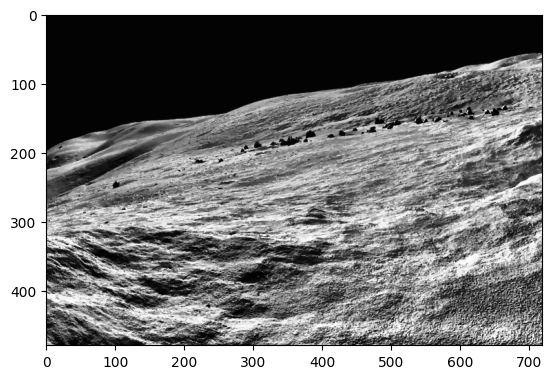

In [ ]:
def preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    if image is None:
        print(f"Could not load image at {image_path}")
        return None

    # Apply CLAHE using skimage to enhance visibility in images
    clahe = exposure.equalize_adapthist(image, clip_limit=0.03)

    # Noise Reduction using Non-Local Means (from skimage)
    # channel_axis=None is used to specify that the image is grayscale
    sigma_est = np.mean(estimate_sigma(clahe, channel_axis=None))
    denoised = denoise_nl_means(clahe, h=1.15 * sigma_est, fast_mode=True, patch_size=5, patch_distance=3, channel_axis=None)

    # Torch-based preprocessing (Gamma correction via torchvision)
    tensor_img = T.ToTensor()(denoised)
    gamma = 1.2
    corrected_img = torch.pow(tensor_img, gamma)
    corrected_img = corrected_img.squeeze().numpy()

    return corrected_img

# Example
preprocessed_image = preprocess_image('/content/render0004.png')
if preprocessed_image is not None:
    plt.imshow(preprocessed_image, cmap='gray')
    plt.show()

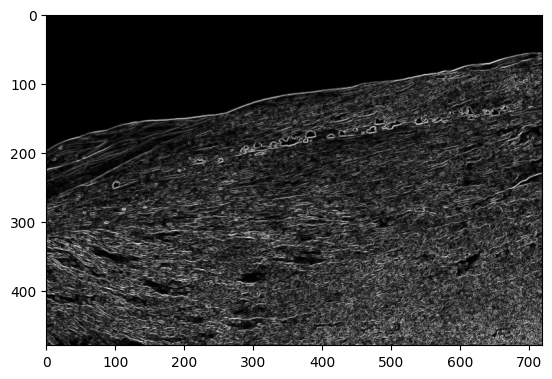

In [ ]:
def detect_edges(image_path):
  image = preprocess_image(image_path)

  # Edge detection using skimage's sobel filter
  edges = filters.sobel(image)

  return edges

# Example
edges_image = detect_edges('/content/render0004.png')
plt.imshow(edges_image, cmap='gray')
plt.show()

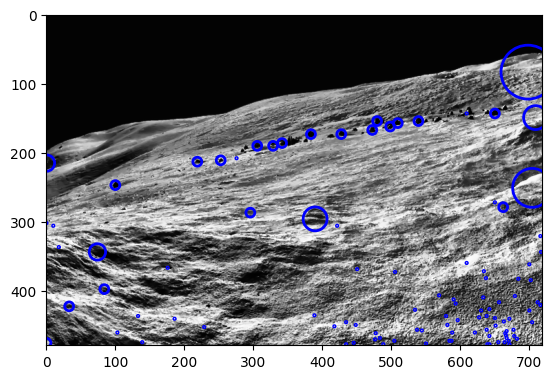

In [ ]:
def detect_boulders(image_path):
    image = preprocess_image(image_path)

    # Blob detection using Difference of Hessian (skimage)
    blobs = blob_doh(image, min_sigma=1, max_sigma=50, num_sigma=10, threshold=0.01)

    # Mark boulders
    fig, ax = plt.subplots()
    ax.imshow(image, cmap='gray')
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color='blue', linewidth=2, fill=False)
        ax.add_patch(c)
    plt.show()

# Example
detect_boulders('/content/render0004.png')

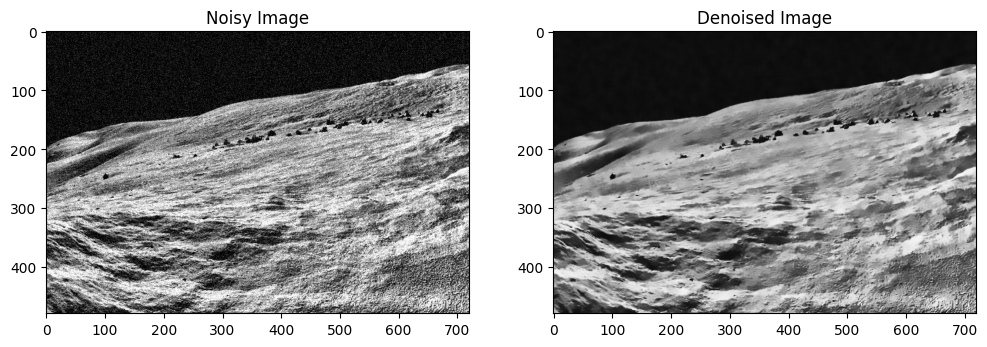

In [ ]:
def low_light_noise_removal(image_path):
    # Load the low-light image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Apply CLAHE for contrast enhancement (optional but useful for low-light images)
    clahe = exposure.equalize_adapthist(image, clip_limit=0.03)

    # Add synthetic noise to simulate real-world low-light conditions (optional)
    noisy_image = random_noise(clahe, mode='gaussian', var=0.01)

    # Estimate the noise standard deviation (sigma) from the image
    sigma_est = np.mean(restoration.estimate_sigma(noisy_image)) # Removed the multichannel argument

    # Apply Non-Local Means (NLM) denoising
    denoised_image = restoration.denoise_nl_means(noisy_image, h=1.15 * sigma_est, fast_mode=True, patch_size=5, patch_distance=6) # Removed the multichannel argument

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.imshow(noisy_image, cmap='gray')
    ax1.set_title('Noisy Image')

    ax2.imshow(denoised_image, cmap='gray')
    ax2.set_title('Denoised Image')

    plt.show()

    return denoised_image

# Example
denoised_image = low_light_noise_removal('/content/render0004.png')

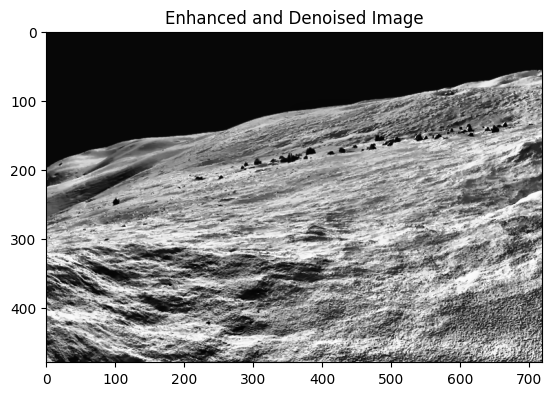

In [ ]:
def enhance_contrast_and_denoise(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Step 1: Contrast enhancement using CLAHE
    clahe = exposure.equalize_adapthist(image, clip_limit=0.03)

    # Step 2: Noise removal using Non-Local Means denoising
    # Removed multichannel argument as it is deprecated
    sigma_est = np.mean(restoration.estimate_sigma(clahe))
    denoised_image = restoration.denoise_nl_means(clahe, h=1.15 * sigma_est, fast_mode=True, patch_size=5, patch_distance=6)

    return denoised_image

# Example
image_path = '/content/render0004.png'
denoised_image = enhance_contrast_and_denoise(image_path)

plt.imshow(denoised_image, cmap='gray')
plt.title('Enhanced and Denoised Image')
plt.show()


In [ ]:
def calculate_snr(denoised_image):
    # Signal: Mean intensity of the bright regions
    signal_region = denoised_image[denoised_image > denoised_image.mean()]
    mu_signal = np.mean(signal_region)

    # Noise: Standard deviation in the darker regions
    noise_region = denoised_image[denoised_image <= denoised_image.mean()]
    sigma_noise = np.std(noise_region)

    snr = mu_signal / sigma_noise
    return snr

snr_value = calculate_snr(denoised_image)
print(f"SNR of the image: {snr_value}")

SNR of the image: 4.927119714895838


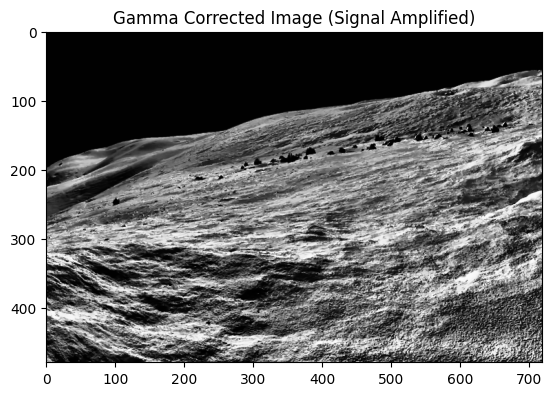

In [ ]:
def amplify_signal(image, gamma=1.2):
    gamma_corrected = exposure.adjust_gamma(image, gamma)
    return gamma_corrected

# Example
gamma_corrected_image = amplify_signal(denoised_image, gamma=1.5)

# Display the gamma-corrected image
plt.imshow(gamma_corrected_image, cmap='gray')
plt.title('Gamma Corrected Image (Signal Amplified)')
plt.show()

SNR before signal amplification: 4.927119714895838
SNR after signal amplification: 5.461771832016346


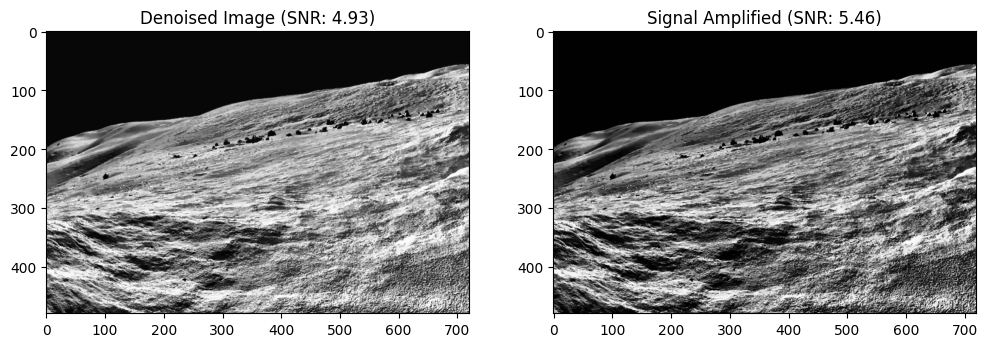

In [ ]:
def improve_snr_image(image_path):
    # Step 1: Enhance contrast and reduce noise
    denoised_image = enhance_contrast_and_denoise(image_path)

    # Step 2: Compute SNR of the denoised image
    snr_value_before = calculate_snr(denoised_image)
    print(f"SNR before signal amplification: {snr_value_before}")

    # Step 3: Amplify the signal using gamma correction
    gamma_corrected_image = amplify_signal(denoised_image, gamma=1.5)

    # Step 4: Compute SNR after signal amplification
    snr_value_after = calculate_snr(gamma_corrected_image)
    print(f"SNR after signal amplification: {snr_value_after}")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.imshow(denoised_image, cmap='gray')
    ax1.set_title(f'Denoised Image (SNR: {snr_value_before:.2f})')

    ax2.imshow(gamma_corrected_image, cmap='gray')
    ax2.set_title(f'Signal Amplified (SNR: {snr_value_after:.2f})')

    plt.show()

    return snr_value_before, snr_value_after
    image_path = '/content/render0004.png'
snr_before, snr_after = improve_snr_image(image_path)